# DragoNN Tutorial: Deep Neural Network (DNN) Models for Regulatory Genomics

## Overview
In this tutorial, we will:

    1) Simulate properties of regulatory DNA sequence
    2) Train high performance DNN models to classify sequences based on their simulated properties
    3) Explore methods to extract simulated sequence properties from a trained model

This tutorial is implemented in python (see this [online python course](https://www.udacity.com/course/programming-foundations-with-python--ud036) for an introduction).

We start by loading the prerequisite modules.

In [1]:
%load_ext autoreload
%autoreload 2
from dragonn.tutorial_utils import (
    get_available_simulations, print_available_simulations,
    print_simulation_info, get_simulation_data,
    inspect_SequenceDNN, get_SequenceDNN,
    train_SequenceDNN, SequenceDNN_learning_curve, test_SequenceDNN,
    interpret_SequenceDNN_distributed,
    interpret_SequenceDNN_integrative
)
%matplotlib inline

Using gpu device 1: GeForce GTX TITAN X (CNMeM is enabled with initial size: 2500 MB, cuDNN 5004)
Using Theano backend.
/users/jisraeli/local/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## 1a. The simulations interface
We can check the available simulations by calling print_available_simulations() 

In [2]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


Transcription factors (TFs) are regulatory proteins that bind DNA sequence to activate and repress genes. These may bind cooperatively or non-cooperatively. The following figure summarizes some of the differences between cooperative and non-cooperative binding:

![TF binding](http://mitra.stanford.edu/kundaje/jisraeli/dragonn/tf_binding.jpg)
taken from François Spitz & Eileen E. M. Furlong. Nature Review Genetics 13, 613-626 (2012).

We will focus on the motif distance property of cooperative TF binding. We will simulate a positve class of sequences in which TFs cooperatively bind motifs positioned closely and a negative class of sequences in which the TFs independently bind motifs positioned independently.

We run this simulation using "simulate_heterodimer_grammar". We start by printing the simulation's documentation, which will summarize what the simulation does and the parameters of the simulation.



In [3]:
print_simulation_info("simulate_heterodimer_grammar")


    Simulates two classes of sequences with motif1 and motif2:
        - Positive class sequences with motif1 and motif2 positioned
          min_spacing and max_spacing
        - Negative class sequences with independent motif1 and motif2 positioned
        anywhere in the sequence, not as a heterodimer grammar

    Parameters
    ----------
    seq_length : int, length of sequence
    GC_fraction : float, GC fraction in background sequence
    num_pos : int, number of positive class sequences
    num_neg : int, number of negatice class sequences
    motif1 : str, encode motif name
    motif2 : str, encode motif name
    min_spacing : int, minimum inter motif spacing
    max_spacing : int, maximum inter motif spacing

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    


## 1b. Getting simulation data

To get simulation data we:
    
    1) Define the simulation parameters
    2) Get simulation data by calling get_simulation_data, which takes as input the simulation name and the simulation parameters.

We will simulate cooperative vs independent binding of SPI1 and IRF, transcription facotrs with important regulatory function in human lymphoblastoid cells. The positive class sequences will contain motifs of SPI1 and IRF positioned 2-5bp apart in a 500bp sequence. The negative class sequences will contain these motifs positioned independetly. We will simulate 10,000 sequences of each type and set the % of G&C nucleotides in the sequence to 40%. Below, we define heterodimer_grammar_simulation_parameters with these settings.

In [4]:
heterodimer_grammar_simulation_parameters = {
    "seq_length": 500,
    "GC_fraction": 0.4,
    "num_pos": 10000,
    "num_neg": 10000,
    "motif1": "SPI1_known4",
    "motif2": "IRF_known20",
    "min_spacing": 2,
    "max_spacing": 5}

Then, we get the simulation_data by calling get_simulation_data with the simulation name and the simulation parameters.

In [5]:
simulation_data = get_simulation_data("simulate_heterodimer_grammar", heterodimer_grammar_simulation_parameters)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the simulation sequences, which provide a numerical representation of the data that is compatible with DNN models. Here are the first 10bp of a sequence in our training data:

In [6]:
simulation_data.X_train[0, :, :, :10]

array([[[ 1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]]])

This matrix represent the 10bp sequence AGTAAGATTT: each column corresponds to a bp, and rows from top to bottom correspond to A/C/G/T. The "1" in the 1st column, 1st row represents the 1st bp A, the "1" in the 2nd column, 3rd row represents the 2nd bp G, etc.

## 2a Setting up a DNN model

Below is a schematic of convolutional neural network (CNN) seuqnece model
![dnn](http://mitra.stanford.edu/kundaje/jisraeli/dragonn/dnn_figure.png)

We proceed to set up the DNN model. We start by inspecting SequenceDNN, which implements a wide range of DNN models and methods to train, test, and interpret them. SequenceDNN uses [keras](http://keras.io/), a deep learning library for [Theano](https://github.com/Theano/Theano) and [TensorFlow](https://github.com/tensorflow/tensorflow), which are popular software packages for deep learning. We start by calling inspect_SequenceDNN which will print a summary of SequenceDNN parameters and methods.

In [7]:
inspect_SequenceDNN()

Sequence DNN models.

Parameters
----------
seq_length : int
    length of input sequence.
use_deep_CNN : bool, optional
    uses 3 layered CNN if True, 1 layered CNN if False.
    Default: False.
num_tasks : int,
    number of tasks. Default: 1.
num_filters : int
    number of 1st layer convolutional filters. Default: 15.
conv_width : int
    width of 1st layer convolutional filters. Default: 15.
pool_width : int
    width of max pooling. Default: 35.
num_filters_2 : int
    number of 2nd layer convolutional filters. Default: 15.
conv_width_2 : int
    width of 2nd layer convolutional filters. Default: 15.
num_filters_3 : int
    number of 3rd layer convolutional filters. Default: 15.
conv_width_3 : int
    width of 3rd layer convolutional filters. Default: 15.
L1 : float
    strength of L1 penalty.
dropout : float
    dropout probability in every convolutional layer. Default: 0.
num_tasks : int
    Number of prediction tasks or labels. Default: 1.
verbose: int
    Verbosity level dur

"Available methods" display the thing you can do with a SequenceDNN model. These include common operations such as training and testing the model, and more complex operations such as extracting insight from trained models. We define deep_cnn_parameters of a 3-layered CNN model for 500bp sequence with three convolutional layer, each with 15 convolutional filters of width 15, followed by maxpooling of width 35.

In [8]:
deep_cnn_parameters = {
    'seq_length': 500,
    'use_deep_CNN': True, # we have to specify this option when using a deep CNN
    'num_filters': 15,
    'conv_width': 15,
    'num_filters_2': 15, # define number and width of convolutiional filters in 2nd and 3rd layers
    'conv_width_2': 15,
    'num_filters_3': 15,
    'conv_width_3': 15,
    'pool_width': 35}

we get the deep_cnn_model by calling get_SequenceDNN with deep_cnn_parameters

In [9]:
deep_cnn_model = get_SequenceDNN(deep_cnn_parameters)

## 2b Training a DNN model

Next, we train the cnn_model by calling train_SequenceDNN with cnn_model and simulation_data. In each epoch, the cnn_model will perform a complete pass over the training data, and update its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, we will print performance metrics for the cnn_model on the validation data. We will early stop training once the loss on the validation stops improving for 3 consecutive epochs. The metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), area under the precision-recall-gain curve ([auPRG](https://papers.nips.cc/paper/5867-precision-recall-gain-curves-pr-analysis-done-right.pdf)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [10]:
train_SequenceDNN(deep_cnn_model, simulation_data)

Training model...
Epoch 0: validation loss: 0.694
Balanced Accuracy: 50.94%	 auROC: 0.532	 auPRC: 0.547	 auPRG: 0.046
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1645	 Num Negatives: 1555	 

Epoch 1: validation loss: 0.684
Balanced Accuracy: 55.07%	 auROC: 0.582	 auPRC: 0.585	 auPRG: 0.150
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.5%	 Num Positives: 1645	 Num Negatives: 1555	 

Epoch 2: validation loss: 0.654
Balanced Accuracy: 60.99%	 auROC: 0.685	 auPRC: 0.675	 auPRG: 0.357
Recall at 5%|10%|20% FDR: 0.4%|0.7%|0.9%	 Num Positives: 1645	 Num Negatives: 1555	 

Epoch 3: validation loss: 0.568
Balanced Accuracy: 70.78%	 auROC: 0.785	 auPRC: 0.766	 auPRG: 0.570
Recall at 5%|10%|20% FDR: 1.3%|3.1%|42.4%	 Num Positives: 1645	 Num Negatives: 1555	 

Epoch 4: validation loss: 0.484
Balanced Accuracy: 77.32%	 auROC: 0.855	 auPRC: 0.838	 auPRG: 0.718
Recall at 5%|10%|20% FDR: 3.9%|30.7%|73.4%	 Num Positives: 1645	 Num Negatives: 1555	 

Epoch 5: validation loss: 0.364
Balanced Accuracy

We can plot the visualize learnnig over the course of training by calling SequenceDNN_learning_curve for cnn_model. This will plot learning curves showing the loss on the training and validation data after each epoch, along with the training early stop poing with minimum validation loss.

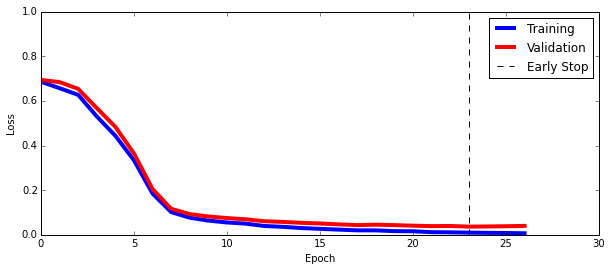

In [11]:
SequenceDNN_learning_curve(deep_cnn_model)

Finally, we test cnn_model on independent test data that was not used to train the model.

In [12]:
test_SequenceDNN(deep_cnn_model, simulation_data)

Test performance:
Balanced Accuracy: 99.00%	 auROC: 0.999	 auPRC: 0.998	 auPRG: 0.998
Recall at 5%|10%|20% FDR: 99.9%|100.0%|100.0%	 Num Positives: 2017	 Num Negatives: 1983	 


## 3 Interpreting DNN models: two approaches

We have a trained model with a high accuracy and auROC. Can infer from this model the simulated motifs and the spacing constraint? Generally, there are two approaches to interpreting SequenceDNN models:

    a) Model-centric approach, interprets model parameters directly, for example, by visualizing individual learned filters and comparing them to motifs.
    
    b) Input sequence-centric approach, which interprets the model in the context of a specific input sequence, for example, by scoring the importance of each nucleotide in the input sequence based on its contribution throughout the model. 

We start with the model-centric approach.

## 3a Interpreting DNN models: the model-centric approach

We visualize the convolutional filters in the first convolutional layer and compare them to the motifs we embedded

Plotting simulation motifs...


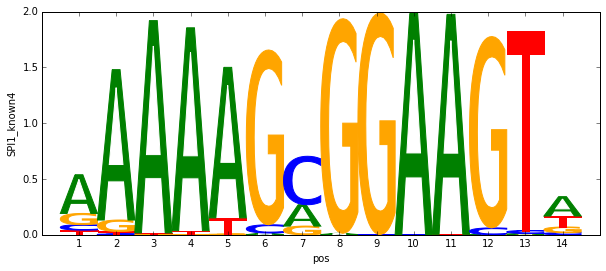

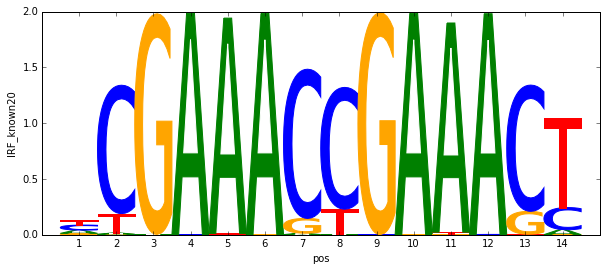

Visualizing convolutional sequence filters in SequenceDNN...


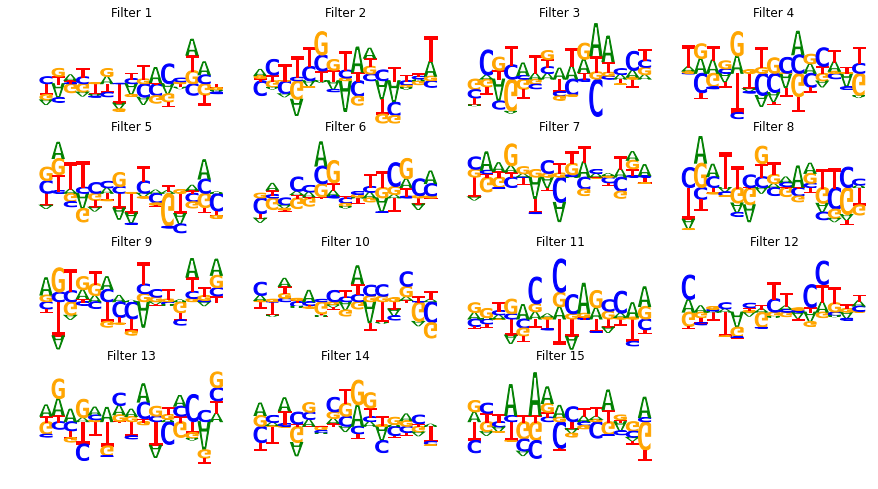

In [13]:
interpret_SequenceDNN_distributed(deep_cnn_model, simulation_data)

Comparing convolutional filters to the simulated motifs, we observe that none of the filters closely resemble the simulated motifs.

## 3b Interpreting DNN models: the input sequence-centric approach

To extract additional insight from the model, we turn to the DeepLIFT method and in-silico mutagenesis (ISM), which estimate the importance of each nucleotide based on the model. We assess these methods by following these steps:

    1) Compute motif scores for SPI1 and IRF throughout the sequence. Sites of embedded motifs will have higher motif scores than the rest of the sequence. 

    2) Compute the importance of each nucleotide in the sequences based on our CNN model using DeepLIFT and ISM.

    3) Compare model-based nucleotide importances to motif scores. We already know that the CNN model is extremely
    accurate, so we expect that a high quality model interpretation method will enable us to identify motif
    sequences and the spacing contraint that characterizes the SPI1-IRF heterodimer grammar.

Done 0
Done 0


/users/jisraeli/local/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


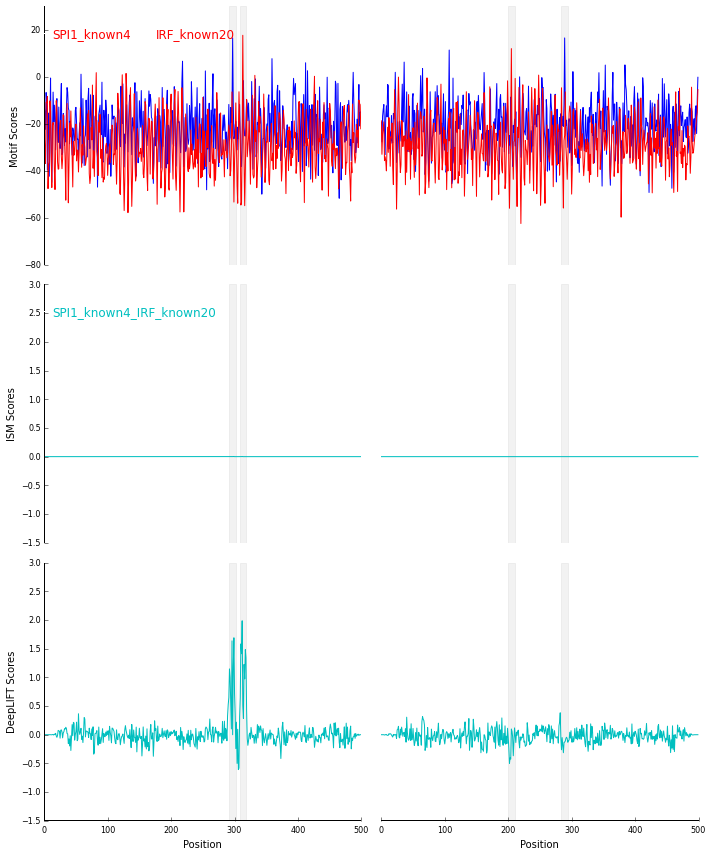

In [14]:
interpret_SequenceDNN_integrative(deep_cnn_model, simulation_data)

We see that DeepLIFT scores correctly highlight all of the nucleotides in the cooperative binding sequence (bottom left) and ignore sequences of motifs tpositioned independently (bottom right). Based on the DeepLIFT scores, we can infer that the SPI1 and IRF motifs are important when they are positioned together but lose their importance when they are positioned independently. ISM scores sometimes highlight some of the heterodimer grammar sequence, but is not sensitive as sensitive as DeepLIFT, and therefore provides less power for inference of the simulated motifs and the motif distance constraint.

## Extras for HW

The tutorial example here touches on general principles of DragoNN model development and interpretation. To gain a deeper insight into the difference between DeepLIFT and ISM for model interpretation, consider the following exercise:

Train, test, and run sequence-centric interpretation for the one layered CNN model used here for the following
simulations:
    1. single motif detection simulation of TAL1 in 1000bp sequence with 40% GC content
    (run print_simulation_info("simulate_single_motif_detection") to see the exact simulation parameters)
    2. motif density localization simulation of 2-4 TAL1 motif instances in the central of 150bp of a total 1000bp
    sequence with 40% GC
    content
    (run print_simulation_info("simulate_motif_density_localization") to see the exact simulation parameters)

Key questions:

    1) What could explain the difference in ISM's sensitivity to the TAL1 motif sequence between the simulations?
    2) What does that tell us about the the scope of ISM for feature discovery? Under what conditions is it likely
    to show sensitivity to sequence features?
    
Starter code is provided below to get the data for each simulation and new cnn model.


In [15]:
single_motif_detection_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

single_motif_detection_simulation_data = get_simulation_data(
    "simulate_single_motif_detection", single_motif_detection_simulation_parameters)

density_localization_simulation_data = get_simulation_data(
    "simulate_motif_density_localization", density_localization_simulation_parameters)

In [16]:
new_deep_cnn_model = get_SequenceDNN(deep_cnn_parameters)